# Trabajo Practico 1
## Maximización del Ratio de Sharpe con Derivadas Numéricas

El ratio de Sharpe está definido como:

$$
S(w) = \frac{w^\top \mu - r_f}{\sqrt{w^\top \Sigma w}}
$$

donde:

- **$w$** es el vector de pesos del portafolio,
- **$\mu$** es el vector de rendimientos esperados,
- **$r_f$** es la tasa libre de riesgo,
- **$\Sigma$** es la matriz de covarianzas.

**Punto 1.**
 
Creamos una clase **`Portfolio`** con el objetivo de facilitar la mecánica de las tantas funciones auxiliares que se requiere para calcular la **ratio de Sharpe** (retornos medios, desvíos, etcétera).
 
Para ejemplificar, utilizamos retornos y tasas libre de riesgo anualizada para 3 activos cualquiera. La tabla con los retornos que ven a continuación ingresa como argumento en forma de lista en la clase antes mencionada:
 
**Retornos por activo**
 
| **A1** | **A2** | **A3** |
|-------:|-------:|-------:|
|   0,10 |   0,05 |   0,20 |
|   0,20 |   0,10 |   0,25 |
|   0,15 |   0,12 |   0,22 |
|   0,12 |   0,08 |   0,21 |
|  -0,10 |  -0,05 |   0,15 |
 
Con los ponderadores iniciales de **[0.3, 0.3, 0.4]** respectivamente.
 
**Los resultados de Retorno y Ratio de Sharpe:**
 
**Sharpe Ratio:** 1.4476070397189127  

**Portfolio Retorno:** 0.12860000000000002
 
Estos resultados se obtienen de calcular el retorno del portfolio para los ponderadores originales que metimos de entrada.

Ya por fuera de la clase portfolio creamos la función que aproxima el gradiente por derivadas numéricas. Trabajamos con w1 y w2, estando w3 implícito en todo momento como 1 - w1 - w2. Esta sustitución nos permitió no tener que calcular de manera explítita la derivada del Sharpe respecto al w3, dado que en verdad trabajamos en R2. 

El gradiente del Sharpe respecto de \(w_1 , w_2\) usando diferencias centrales es:

\[
\begin{bmatrix}
\dfrac{S(w_1+h,\,w_2) - S(w_1-h,\,w_2)}{2h} \\
\dfrac{S(w_1,\,w_2+h) - S(w_1,\,w_2-h)}{2h}
\end{bmatrix}
\]

 Dados los retornos del ejemplo y los weights iniciales, el gradiente (w1, w2) aún sin optimizar es:

 [-3.31964134 -2.76820257]

In [8]:
import numpy as np
import matplotlib.pyplot as plt


class Portfolio():
    def __init__(self, weights, returns, rf, penalty = False):
        # Weighst = tupla con los w de los 3 activos
        # Returns = Lista de 3 tuplas con los retornos de los 3 activos
        self.penalty = penalty
        self.returns = np.array(returns)
        self.mus = self.mu()
        self.weights = self.check_weights(weights)
        self.rf = rf
        self.cov_matrix = np.cov(returns)

    def check_weights(self, weights):
        check = 0
        for i in weights:
            check += i
        if check != 1:
            raise ValueError("La suma de los weights debe ser 1.")

        # Si vienen 2 weights, infiero el tercero
        if len(weights)==2:
            weights = np.append(weights, 1-weights.sum())
        return np.array(weights)

    def mu(self):
        prom_r = []
        for i in self.returns:
            i = np.mean(i)
            prom_r.append(i)
        return np.array(prom_r)

    def portfolio_return(self, weights=None):
        if weights is None:
            weights = self.weights
        return weights @ self.mus

    def portfolio_volatility(self, weights=None):
        if weights is None:
            weights = self.weights
        return np.sqrt(weights @ self.cov_matrix @ weights)

    def sharpe_ratio(self, weights=None, ponderador = 15000): #cambiar nombre a menos sharpe/o agregar un parametro que haga el return negativo
        if weights is None:
            weights = self.weights
        elif len(weights)==2:
            weights = np.append(weights,1-sum(weights))
        S = (self.portfolio_return(weights) - self.rf) / self.portfolio_volatility(weights)
        if self.penalty:
            # Penaliza si hay pesos negativos
            penalty_term = ponderador * np.sum(np.minimum(weights, 0)**2)
            return S - penalty_term
        else:
            return S

def gradient_sharpe(cartera, w):
        """
        Esta función hace la derivada centrada del
        ratio de Sharpe, evaluada en el punto que
        el usuario ingrese.
        Por default usa como funcion a derivar el 
        ratio de sharpe sin la penalidad, pero el 
        usuario puede elegir si desea derivar la 
        funcion que involucra la penalidad cuando
        alguno de los weights son < 0.
        
        Returns: Gradiente
        """
        h = 10e-4  # El movimiento marginal de la derivada
        if w is None:
            w = cartera.weights[:2:]
        #Derivada parcial resp de w1:
        
        fx = (cartera.sharpe_ratio(np.array([w[0] + h, w[1]])) - cartera.sharpe_ratio(np.array([w[0] - h, w[1]])))/(2*h)
        #Derivada parcial resp de w2:
        fy = (cartera.sharpe_ratio(np.array([w[0], w[1] + h])) - cartera.sharpe_ratio(np.array([w[0], w[1] - h])))/(2*h)

        return np.array([fx, fy]) #Gradiente

##### Pruebas #####
# Estos son los weights inciales de la consigna       
weights = (0.3, 0.3, 0.4)
# Estos son ejemplos de los retornos anualizados
returns = [(0.10, 0.20, 0.15, 0.12, -0.10),
    (0.05, 0.10, 0.12, 0.08, -0.05),
    (0.20, 0.25, 0.22, 0.21, 0.15)]
# tasa libre de riesgo anualizada
rf = 0.03

# Este objeto es para calcular ratio de sharp y retorno del portafolio
p = Portfolio(weights, returns, rf) 

print("Sharpe Ratio:", p.sharpe_ratio())
print("Portfolio Return:", p.portfolio_return())



Sharpe Ratio: 1.4476070397189125
Portfolio Return: 0.12860000000000002


**Punto 2.**

En este punto desarrollamos el algoritmo de descenso por gradiente para minimizar la función -Sharpe(w). Dado el ejemplo ya mencionado, los resultados son:

Weights óptimos: [-0.5238829, 0.21212779, 1.31175511]

Sharpe máximo: 22.427838339957155

Para maximizar el Sharpe dadas las características del ejemplo propuesto es necesario shortearse en el activo 1, invertir una pequeña fracción en el activo 2, y estar fuertemente comprado en el tercer activo.

**Punto 3.**

Para la implementación de la penalidad lo que hicimos fue integrarla a la función que calcula el ratio de Sharpe (pto 1), de manera tal que, si el usuario desea crear el objeto portafolio que posteriormente realice la optimización con la penalidad a posiciones short, pueda hacerlo cambiando el paramento “Penalty” (que por default está en False y optimiza sin penalidad) a True.

Nuestra intuición es que necesitábamos una función que no sea binaria en la diferenciación de casos y uniforme en el castigo: Si el weight es mayor o igual a cero está bien, y si es menor que cero está mal y se añade a la función Sharpe una penalidad no variable. Esto es porque consideramos que tener un weight que sea -1 es malo, pero peor es que valga -3, entonces intentamos diseñar una función que sea capaz de aplicar la penalidad de manera proporcional a la necesidad.

La función penalidad en cuestión es también C1:

$$
P(\mathbf{w})=\sum_{i=1}^{3}(\min\{w_i,0\})^2
$$

Para el ejemplo (retornos y weights iniciales) dado, la optimización con penalización a las posiciones short arrojan los siguientes resultados:

Weights óptimo: [-3.22644118e-04  1.62680280e-05  1.00030638e+00] 

Sharpe: 4.828545895347135

En comparación con la optimización libre, el ratio de Sharpe es bastante menor, lo cual era de esperar si ponemos atención a los weights de la anterior optimización: posición vendida en 1 de 3 activos para maximizar el ratio de Sharpe. De ahí era predecible que iba a caer el Sharpe si no permitíamos estar vendido en ningún activo que conforme el portafolio.

In [9]:


def gdscent(cartera, e = 10e-5,n=100000,graph=False):
    """ Esta función recibe por parte del usuario un vector de ponderadores inicial del portafolio. Mediante el uso de derivadas 
    centradas y el algoritmo de descenso por gradiente de -f(X) maximiza el ratio de Sharpe. """

    # En cada iteración, se debera crear un nuevo vector de weights que se convertira otro objeto de la clase Portfolio.
    # Los retornos y la risk free se mantienen con el mismo valor (W0).
    w0 = cartera.weights[:2:]
    rf = cartera.rf
    historial_w = np.array([])
    historial_sharpes = np.array([])
    # Evaluo el sharpe en el punto W0
    # Agregamos un menos adelante, porque queremos maximizar una función con un metodo de minimizacion
    for i in range(n):
        Y0 = cartera.sharpe_ratio(w0) 

        # Calculo la derivada centrada en W0
        dY = gradient_sharpe(cartera, w0)

        # Calculo mi nuevo w0 retrocediendo a tasa e en contra del gradiente, la direccion de maximo crecimiento
        w0 = w0 - e * (-dY)

        # Evaluo el shrape en mi nuevo punto W1
        Y1 = cartera.sharpe_ratio(w0)
        
        #Si la distancia en valor absoluto entre f(W1) y f(W0) es muy chica, decimos que encontramos el vector de weights que maximiza el sharpe dada una rf
        if abs(Y1-Y0) < 10e-8:
            w0 = np.append(w0,1-sum(w0))
            sharpe = cartera.sharpe_ratio(w0)
            if graph:
                x = 0 
                # w0 es el vector de weights que maximiza el sharpe
                # sharpe es el sharpe max
                # historial de w y sharpes nos serviran para graficar la trayectoria.
                return w0 , sharpe, historial_w , historial_sharpes
            return w0 , sharpe
        else:
            historial_w = np.append(historial_w, [ [w0[0], w0[1]] ])
            historial_sharpes = np.append(historial_sharpes, -Y1)
            continue


##### Pruebas #####        
# Este es objeto de optimizacion con penalidad
p = Portfolio(weights, returns, rf, True) # Para optimizar sin penalidad cambiar el True por False


w_opt, sharpe_opt, recorrido_w, recorrido_sharpe = gdscent(p, graph=True)
print("Óptimo:", w_opt, "Sharpe:", sharpe_opt)
p.weights = w_opt
print(p.weights)

Óptimo: [-3.22644118e-04  1.62680280e-05  1.00030638e+00] Sharpe: 4.828545895347135
[-3.22644118e-04  1.62680280e-05  1.00030638e+00]


**Punto 4.**

En este inciso de gráficas, realizamos 3 funciones destinadas a realizar 2 gráficos:

    - La función del ratio de Sharpe, con el vector de weights óptimos y el Sharpe evaluado en ese vector de weights.
    - Las curvas de nivel del ratio de Sharpe, junto con la trayectoria del optimizador del descenso por gradiente. Está señalado el gráfico: 
        - Curvas de nivel de la Función
        - Punto de partida: weights iniciales ingresados por el usuario que deben sumar 1
        - Punto final: weights óptimos 
        - Máximo Sharpe Sharpe(w1*, w2*) y w3* está implícito como 1 - w1 - w2
        - Trayectoria del optimizador  
    
Para el ejemplo con el que venimos trabajando en los puntos anteriores, las gráficas sin la penalización a las posiciones short se ven así:    

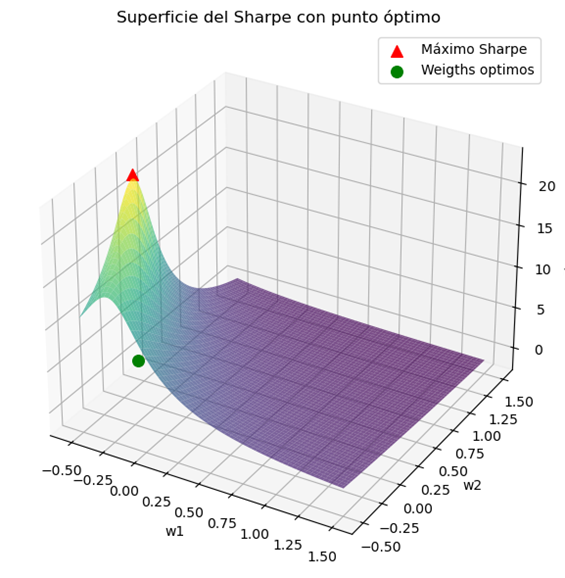
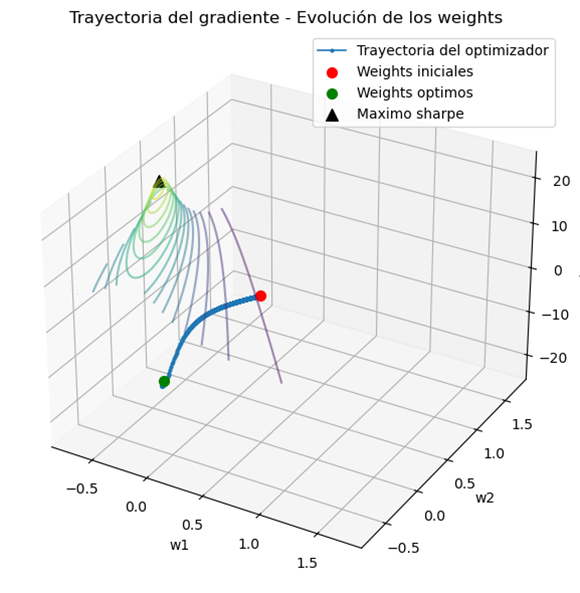

Para el caso de penalización a las posiciones vendidas, los gráficos del mismo ejemplo son:

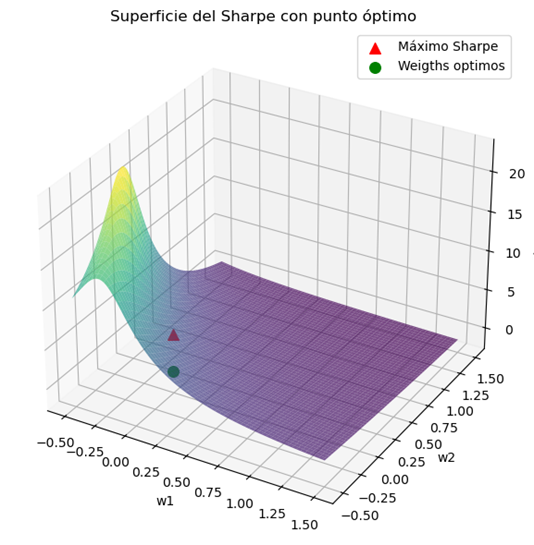
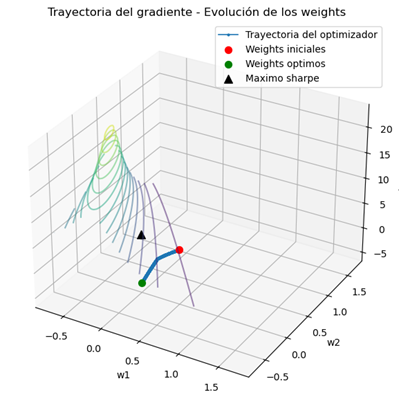

En línea con las conclusiones sacadas en en los puntos 2 y 3 respecto a la diferencia en los weights óptimos y el ratio de Sharpe en los casos de posiciones libres y posiciones (short) restringidas, era de esperar en este ejemplo que al aplicar una restricción sobre las posiciones vendidas se reduzca el Sharpe. Como bien dijimos, esto se debe a que estamos privando al optimizador de tomar el camino que en condiciones normales maximiza el Sharpe: Estar short en el activo 1.

Óptimo: [-3.22644118e-04  1.62680280e-05  1.00030638e+00] Sharpe: 4.828545895347135


c:\Users\Admin\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


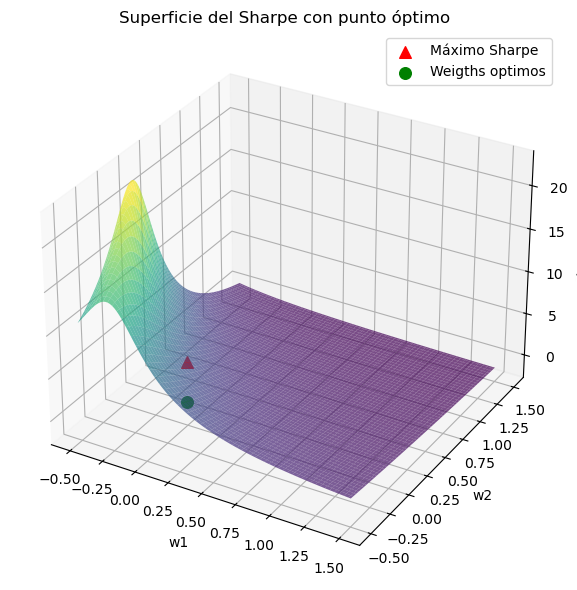

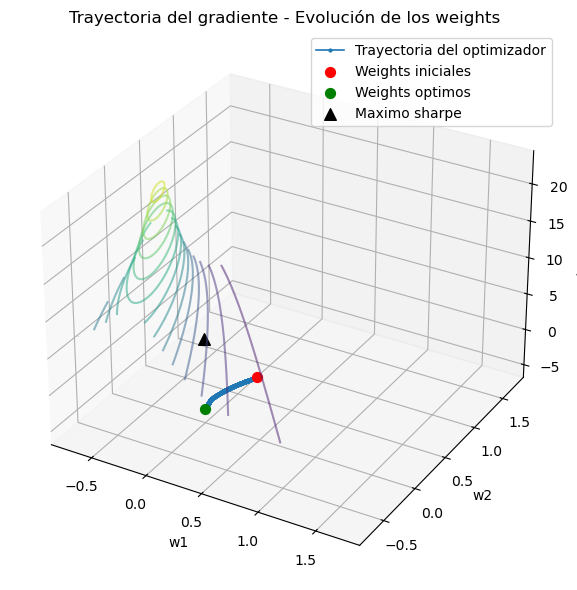

In [6]:
def plot_sharpe_superficie(cartera, w_opt, sharpe_opt,
                           w1_lim=(-0.5,1.5), w2_lim=(-0.5,1.5), grid=120):
    """
    Esta funcion grafica la funcion sharpe. Incorpora (1) un vector con 
    los weights optimos (w1*, w2*, 0) dado que el w3* esta implicito 
    como w3* = 1 - w1* - w2*, y (2) el maximo ratio de sharpe alcanzado,
    es decir la funcion Sharpe evaluada en los weights optimos, que se 
    encurntra en el plano 3D como el vector (w1*, w2*, sharpe(w1*, w2*)). 
    Notacion:
        - cartera: Objeto de la calse portafolio que se debe 
        como argumento de la funcion
        - Superficie z = S(w1,w2,1-w1-w2) y el punto óptimo.
        - sharpe_xy: función (w1,w2) -> Sharpe positivo
        - w_opt: vector (w1,w2,w3) óptimo
        - sharpe_opt: valor Sharpe en el óptimo
    """
    w1 = np.linspace(*w1_lim, grid)
    w2 = np.linspace(*w2_lim, grid)
    W1, W2 = np.meshgrid(w1, w2)

    Z = np.empty_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            Z[i,j] = cartera.sharpe_ratio(np.array([W1[i,j], W2[i,j], 1-W1[i,j]-W2[i,j]]))

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(W1, W2, Z, cmap='viridis', alpha=0.7, rstride=2, cstride=2)
    ax.scatter(w_opt[0], w_opt[1], sharpe_opt,
               c='red', s=70, marker='^', label='Máximo Sharpe')
    
    # Agregamos el par de weights optimos
    ax.scatter(w_opt[0], w_opt[1], 0,
               c='green', s=70, marker='o', label='Weigths optimos')


    ax.set_xlabel('w1'); ax.set_ylabel('w2'); ax.set_zlabel('Sharpe')
    ax.set_title('Superficie del Sharpe con punto óptimo')
    ax.legend()
    plt.tight_layout(); plt.show()

def curvas_de_nivel(cartera, xlim, ylim, puntos =120, margen=0.1):
    """
    Esta funcion genera la grilla con w1, w2, y el Sharpe para graficar curvas
    de nivel. Es una funcion auxiliar de plot_trayectoria_gradiente.
    
    Notación:
        - cartera es el objeto portafolio que se debe ingresar como argumento
        de la funcion.
        - xlim, ylim: tuplas con los límites (min,max) de w1 y w2 a graficar.
        - puntos: cantidad de puntos en la grilla.
        - margen: fracción extra alrededor de los límites para adecuar la 
        grafica a la trayectoria del optimizador y tener margen en los bordes.
    """
    x_min, x_max = xlim #Defino los límites
    y_min, y_max = ylim
    dx, dy = x_max - x_min, y_max - y_min #Calculo el largo y el ancho que va a tener la grafica

    x = np.linspace(x_min - margen*dx, x_max + margen*dx, puntos) 
    y = np.linspace(y_min - margen*dy, y_max + margen*dy, puntos)
    W1, W2 = np.meshgrid(x, y)

    Z = np.full_like(W1, np.nan, dtype=float)
    for i in range(puntos):
        for j in range(puntos):
            w1, w2 = W1[i, j], W2[i, j]
            w3 = 1 - w1 - w2
            if w3 >= 0:   # restricción simplex
                w = np.array([w1, w2, w3])
                Z[i, j] = cartera.sharpe_ratio(w) #llamamos a la función sharpe 
    return W1, W2, Z


def plot_trayectoria_gradiente(cartera, recorrido_w, recorrido_sharpe,
                               w_opt=None, sharpe_opt=None):
    """
    Esta funcion grafica la trayectoria del optimizador de descenso 
    por gradiente de -Sharpe en un plano 3D que contiene a (w1, w2, Sharpe), 
    y w3 se encuentra implicita como w3 = 1 - w1 - w2.
    Mediante el llamado a la funcion curvas_de_nivel, se incorpora al plano 
    las curvas de nivel de la funcion Sharpe.
    Notacion:
    cartera: Objeto de la clase portafolio que se debe ingresar como argunento
    de la funcion.
    recorrido_w: (k,2) con pares (w1,w2) por iteración
    recorrido_sharpe: (k,) valores de Sharpe por iteración
    """
    hw = np.asarray(recorrido_w, dtype=float)
    if hw.ndim == 1: hw = hw.reshape(-1,2)
    S = np.asarray(recorrido_sharpe, dtype=float)

    x,y,z = hw[:,0], hw[:,1], S

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    W1, W2, Z = curvas_de_nivel(cartera, (-0.5,1.5), (-0.5,1.5))
    ax.contour(W1, W2, Z, levels=20, cmap='viridis', alpha=0.5)

    ax.plot(x, y, z, '-o', ms=2, lw=1.2, label='Trayectoria del optimizador')
    ax.scatter(x[0], y[0], z[0], c='red', s=50, label='Weights iniciales')
    ax.scatter(x[-1], y[-1], z[-1], c='green', s=50, label='Weights optimos')

    if w_opt is not None and sharpe_opt is not None:
        ax.scatter(w_opt[0], w_opt[1], sharpe_opt,
                   c='black', s=70, marker='^', label='Maximo sharpe')

    ax.set_xlabel('w1'); ax.set_ylabel('w2'); ax.set_zlabel('Sharpe')
    ax.set_title('Trayectoria del gradiente - Evolución de los weights')
    ax.legend()
    plt.tight_layout(); plt.show()

##### Pruebas ##### 


# Estos son los objetos portafolio para graficar y optimizar
# p_Grafico no tiene penalidad, p_Optim si
# Están creados con los mismos weights y retornos
p_Grafico = Portfolio(weights, returns, rf)
p_Optim = Portfolio(weights, returns, rf, True) # Para optimizar sin penalidad cambiar el True por False


w_opt, sharpe_opt, recorrido_w, recorrido_sharpe = gdscent(p_Optim, graph=True)
print("Óptimo:", w_opt, "Sharpe:", sharpe_opt)


plot_sharpe_superficie(p_Grafico, w_opt, sharpe_opt)
plot_trayectoria_gradiente(p_Grafico, recorrido_w, recorrido_sharpe, w_opt, sharpe_opt)



Aquí dejamos también otros 2 ejemplos (de muchos) con los que probamos el algorítmo:

**Retornos por activo**
 
| **A1** | **A2** | **A3** |
|-------:|-------:|-------:|
|   0,04 |   0,05 |   0,20 |
|   0,07 |   0,10 |   0,25 |
|   0,09 |   0,12 |   0,22 |
|   0,1 |   0,08 |   0,21 |
|  -0,10 |  -0,05 |   0,15 |


**Retornos por activo**
 
| **A1** | **A2** | **A3** |
|-------:|-------:|-------:|
|   0,10 |   0,05 |   0,20 |
|   0,20 |   0,10 |   0,25 |
|   0,15 |   0,12 |   0,22 |
|   0,12 |   0,08 |   0,21 |
|  -0,10 |  -0,05 |   0,15 |